In [62]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier
df1 = pd.read_csv('balanced_group_stratified_fold_0.csv')
df2 = pd.read_csv('balanced_group_stratified_fold_1.csv')
df3 = pd.read_csv('balanced_group_stratified_fold_2.csv')
df4 = pd.read_csv('balanced_group_stratified_fold_3.csv')
df5 = pd.read_csv('balanced_group_stratified_fold_4.csv')

In [63]:
all_dfs = [df1, df2, df3, df4, df5]  # or load from a list
combined_df = pd.concat(all_dfs, ignore_index=True)

In [64]:
combined_df.shape

(651696, 26)

In [65]:
# 2. Drop duplicates if necessary
combined_df = combined_df.drop_duplicates()

In [66]:
combined_df = combined_df.drop(columns=['Test'])

In [67]:
combined_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.784110,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.683949,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.327514,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.347273,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.337194,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.806674,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.749625,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.741463,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.730336,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267


In [68]:
# 3. Re-split by group while preserving class balance
# GroupShuffleSplit doesn't balance classes itself, so we implement a custom version
def balanced_group_split(df, group_col, label_col, test_size=0.2, random_state=42):
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    groups = df[group_col]
    labels = df[label_col]
    
    # Use splitter to get train/test group indices
    for train_idx, test_idx in splitter.split(df, labels, groups):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        break

    # Optional: Rebalance classes in training and testing (downsample majority)
    def balance(df):
        df_pos = df[df[label_col] == 1]
        df_neg = df[df[label_col] == 0]
        n = min(len(df_pos), len(df_neg))
        return pd.concat([df_pos.sample(n, random_state=42), df_neg.sample(n, random_state=42)])

    train_df_balanced = balance(train_df)
    test_df_balanced = balance(test_df)

    # Add 'Test' column
    df['Test'] = False
    df.loc[test_df_balanced.index, 'Test'] = True
    return df

In [69]:
# 4. Apply the function to get new train/test assignment
final_df = balanced_group_split(combined_df, group_col='group_id', label_col='Same_Complex')


In [70]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [10]:
# final_df.to_csv('final_train_test_df.csv', index=False)

In [11]:
final_df

,Gene_B,complex_id_B,Gene_A,complex_id_A,global_index,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_CP_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,...,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation,Gene_1,Gene_2,pair_id,pairwise_label,Same_Complex,group_id,Test
0,MRPL20,CPX-5226,MRPS30,CPX-5226,170548297,0.055306,-0.049358,0.058200,-0.009567,0.014625,...,0.810524,0.769859,0.350919,MRPL20,MRPS30,MRPL20_MRPS30,1,1,12,False
1,SGCD,CPX-2424,SGCB,CPX-2454,167189667,0.102524,0.103210,0.038960,0.021262,0.010275,...,0.752542,0.745347,0.271149,SGCB,SGCD,SGCB_SGCD,0,1,148,True
2,UBA52,CPX-7665,RPL41,CPX-5183,162534628,0.303719,0.218867,0.328298,0.314337,0.277950,...,0.336932,0.328170,0.100595,RPL41,UBA52,RPL41_UBA52,0,1,37,False
3,RPS5,CPX-5223,RPS23,CPX-5223,168689581,0.350182,0.367019,0.375344,0.169027,0.355274,...,0.359518,0.258161,-0.177412,RPS23,RPS5,RPS23_RPS5,1,1,226,False
4,RPL28,CPX-7664,RPL18,CPX-7664,161988725,0.379828,0.521894,0.561702,0.341592,0.433050,...,0.381279,0.266353,0.390724,RPL18,RPL28,RPL18_RPL28,1,1,37,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651691,GID4,CPX-7901,LRRC59,NaN,73491352,0.058076,0.103925,0.168920,-0.006816,0.029619,...,0.864956,0.850807,0.290961,GID4,LRRC59,GID4_LRRC59,0,0,144,False
651692,ZGLP1,NaN,PIGY,CPX-6502,102892472,-0.087258,-0.067971,0.159982,-0.062981,-0.062357,...,0.751085,0.711430,0.445760,PIGY,ZGLP1,PIGY_ZGLP1,0,0,390,False
651693,PPP1R12C,NaN,NCOA2,CPX-816,13506443,0.160041,0.016289,-0.046582,-0.068155,-0.058433,...,0.828842,0.800971,0.286153,NCOA2,PPP1R12C,NCOA2_PPP1R12C,0,0,148,False
651694,MAPKAPK5,NaN,SNRPB,CPX-26467,116784298,-0.013332,0.022776,0.028492,-0.094243,-0.051776,...,0.739071,0.747962,0.426305,MAPKAPK5,SNRPB,MAPKAPK5_SNRPB,0,0,267,False


In [12]:


# exported_pipeline = make_pipeline(
#     StackingEstimator(estimator=RandomForestClassifier(
#         bootstrap=True, criterion="entropy", max_features=0.45,
#         min_samples_leaf=3, min_samples_split=2, n_estimators=100
#     )),
#     Normalizer(norm="l1"),
#     SGDClassifier(
#         alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
#         learning_rate="constant", loss="squared_hinge",
#         penalty="elasticnet", power_t=0.5
#     )
# )

# exported_pipeline = GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features=0.6000000000000001, min_samples_leaf=4, min_samples_split=19, n_estimators=100, subsample=0.8)

In [13]:
FEATURES = ['scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation']

LABEL = ['Same_Complex']


In [14]:
X = final_df[FEATURES]  # use your feature columns
y = final_df['Same_Complex']   # binary labels

X_train = X[~final_df['Test']]
y_train = y[~final_df['Test']]
X_test = X[final_df['Test']]
y_test = y[final_df['Test']]

In [15]:
# exported_pipeline.fit(X_train, y_train)

In [16]:
# exported_pipeline

In [17]:
# X_test = final_df[final_df['Test']][FEATURES]

# y_pred = exported_pipeline.predict(X_test)

In [18]:
# # Class predictions
# y_pred = exported_pipeline.predict(X_test)

# # If needed: decision function or probability scores
# if hasattr(exported_pipeline[-1], "decision_function"):
#     y_scores = exported_pipeline.decision_function(X_test)
# elif hasattr(exported_pipeline[-1], "predict_proba"):
#     y_scores = exported_pipeline.predict_proba(X_test)[:, 1]
#     print(exported_pipeline) # only if available

# # ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# # PR curve
# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# ap_score = average_precision_score(y_test, y_scores)

# import matplotlib.pyplot as plt

# # ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

# # PR Curve
# plt.figure()
# plt.plot(recall, precision, label=f"AP = {ap_score:.3f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

In [19]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import Normalizer
# from sklearn.pipeline import make_pipeline

# # Recreate the logic without TPOT's custom StackingEstimator
# rf = RandomForestClassifier(
#     bootstrap=True, criterion="entropy", max_features=0.45,
#     min_samples_leaf=3, min_samples_split=2, n_estimators=100, random_state=42
# )

# sgd = SGDClassifier(
#     alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
#     learning_rate="constant", loss="squared_hinge",
#     penalty="elasticnet", power_t=0.5, random_state=42
# )

# # Manual stacking: fit RF, use its outputs as a feature
# rf.fit(X_train, y_train)
# rf_outputs = rf.predict_proba(X_train)[:, 1].reshape(-1, 1)  # or use rf.decision_function if needed

# # Stack this with the original X_train
# import numpy as np
# X_train_stacked = np.hstack((X_train.values, rf_outputs))

# # Normalize
# from sklearn.preprocessing import Normalizer
# normalizer = Normalizer(norm='l1')
# X_train_norm = normalizer.fit_transform(X_train_stacked)

# # Fit final classifier
# sgd.fit(X_train_norm, y_train)


In [20]:
# # Predict with RF first
# rf_test_outputs = rf.predict_proba(X_test)[:, 1].reshape(-1, 1)
# X_test_stacked = np.hstack((X_test.values, rf_test_outputs))
# X_test_norm = normalizer.transform(X_test_stacked)

# y_pred = sgd.predict(X_test_norm)

In [21]:
# y_scores = sgd.decision_function(X_test_norm)  

In [22]:
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# # ROC curve
# fpr, tpr, _ = roc_curve(y_test, y_scores)
# roc_auc = auc(fpr, tpr)

# # PR curve
# precision, recall, _ = precision_recall_curve(y_test, y_scores)
# ap_score = average_precision_score(y_test, y_scores)

In [23]:
# import matplotlib.pyplot as plt

# # ROC Curve
# plt.figure()
# plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
# plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid(True)
# plt.show()

# # PR Curve
# plt.figure()
# plt.plot(recall, precision, label=f"AP = {ap_score:.3f}")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")
# plt.legend()
# plt.grid(True)
# plt.show()


In [24]:

from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier


In [25]:
# LinearSVC(max_iter=10000, verbose=0, random_state=42)
# RandomForestClassifier(n_estimators=100, n_jobs=-1)
# LogisticRegression(max_iter=1000)

exported_pipeline = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(
        bootstrap=True, criterion="entropy", max_features=0.45,
        min_samples_leaf=3, min_samples_split=2, n_estimators=100
    )),
    Normalizer(norm="l1"),
    SGDClassifier(
        alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
        learning_rate="constant", loss="squared_hinge",
        penalty="elasticnet", power_t=0.5
    )
)

gb_exported_pipeline = GradientBoostingClassifier(learning_rate=0.5, max_depth=10, max_features=0.6000000000000001, min_samples_leaf=4, min_samples_split=19, n_estimators=100, subsample=0.8)

In [26]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import Normalizer
# from sklearn.pipeline import make_pipeline

# # Recreate the logic without TPOT's custom StackingEstimator
# rf = RandomForestClassifier(
#     bootstrap=True, criterion="entropy", max_features=0.45,
#     min_samples_leaf=3, min_samples_split=2, n_estimators=100, random_state=42
# )

# sgd = SGDClassifier(
#     alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.75,
#     learning_rate="constant", loss="squared_hinge",
#     penalty="elasticnet", power_t=0.5, random_state=42
# )

# # Manual stacking: fit RF, use its outputs as a feature
# rf.fit(X_train, y_train)
# rf_outputs = rf.predict_proba(X_train)[:, 1].reshape(-1, 1)  # or use rf.decision_function if needed

# # Stack this with the original X_train
# import numpy as np
# X_train_stacked = np.hstack((X_train.values, rf_outputs))

# # Normalize
# from sklearn.preprocessing import Normalizer
# normalizer = Normalizer(norm='l1')
# X_train_norm = normalizer.fit_transform(X_train_stacked)

# # Fit final classifier
# sgd.fit(X_train_norm, y_train)

# # Predict with RF first
# rf_test_outputs = rf.predict_proba(X_test)[:, 1].reshape(-1, 1)
# X_test_stacked = np.hstack((X_test.values, rf_test_outputs))
# X_test_norm = normalizer.transform(X_test_stacked)

# y_pred = sgd.predict(X_test_norm)

# y_scores = sgd.decision_function(X_test_norm)  

In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import Normalizer
import numpy as np

class ManualStackingSGD(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 rf_params=None,
                 sgd_params=None,
                 norm='l1'):
        self.rf_params = rf_params or {
            'bootstrap': True,
            'criterion': "entropy",
            'max_features': 0.45,
            'min_samples_leaf': 3,
            'min_samples_split': 2,
            'n_estimators': 100,
            'random_state': 42
        }
        self.sgd_params = sgd_params or {
            'alpha': 0.01,
            'eta0': 0.01,
            'fit_intercept': False,
            'l1_ratio': 0.75,
            'learning_rate': "constant",
            'loss': "squared_hinge",
            'penalty': "elasticnet",
            'power_t': 0.5,
            'random_state': 42
        }
        self.norm = norm

        self.rf = RandomForestClassifier(**self.rf_params)
        self.sgd = SGDClassifier(**self.sgd_params)
        self.normalizer = Normalizer(norm=self.norm)

    def fit(self, X, y):
        self.rf.fit(X, y)
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.fit_transform(X_stacked)
        self.sgd.fit(X_norm, y)
        return self

    def predict(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.predict(X_norm)

    def decision_function(self, X):
        rf_scores = self.rf.predict_proba(X)[:, 1].reshape(-1, 1)
        X_stacked = np.hstack((X.values if hasattr(X, "values") else X, rf_scores))
        X_norm = self.normalizer.transform(X_stacked)
        return self.sgd.decision_function(X_norm)

def get_model_outputs(model, X_train, y_train, X_test):

    print('fitting')
    model.fit(X_train, y_train)

    print('Outputs:')
    outputs = {
        'model': model,
        'predictions': model.predict(X_test)
    }
    print(outputs)

    if hasattr(model, "predict_proba"):
        print('getting probabilities')
        outputs['probabilities'] = model.predict_proba(X_test)[:, 1]
    else:
        print('no probs available')
        outputs['probabilities'] = None

    if hasattr(model, "decision_function"):
        print('getting decision scores')
        outputs['decision_scores'] = model.decision_function(X_test)
    else:
        print('no decision scores available')
        outputs['decision_scores'] = None

    return outputs


In [28]:
# # Instantiate and train the custom stacked model
# stacked_model = ManualStackingSGD()
# stacked_model.fit(X_train, y_train)

# # Evaluate on test data
# stacked_outputs = get_model_outputs(stacked_model, X_test)

# # Access outputs
# y_pred = stacked_outputs['predictions']
# y_prob = stacked_outputs['probabilities']
# y_scores = stacked_outputs['decision_scores']


In [29]:
# def get_model_outputs(model, X_train, y_train, X_test):
#     model.fit(X_train, y_train)
    
#     outputs = {
#         'model': model,
#         'predictions': model.predict(X_test)
#     }

#     if hasattr(model, "predict_proba"):
#         outputs['probabilities'] = model.predict_proba(X_test)[:, 1]
#     else:
#         outputs['probabilities'] = None

#     if hasattr(model, "decision_function"):
#         outputs['decision_scores'] = model.decision_function(X_test)
#     else:
#         outputs['decision_scores'] = None

#     return outputs

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc
)
import numpy as np
from tqdm import tqdm  
from sklearn.metrics import average_precision_score
models = {
        "Logistic Regression": LogisticRegression(max_iter=10000),
        "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1),
        "SGD": SGDClassifier(loss='log_loss', max_iter=10000, random_state=42),
        "LinearSVC": LinearSVC(max_iter=10000, verbose=0, random_state=42),
        "TPOT Gradient Boosting": gb_exported_pipeline, 
        "TPOT Stacked RF SGD":  ManualStackingSGD()
    }



In [39]:
all_model_results = {}

for name, model in tqdm(models.items(), desc="Fitting models"):
    print(name)
    try:
        result = get_model_outputs(model, X_train, y_train, X_test)
        all_model_results[name] = result
    except Exception as e:
        print(f"⚠️ Error with model '{name}': {e}")


Fitting models:   0%|          | 0/6 [00:00<?, ?it/s]

Logistic Regression
fitting


Fitting models:  17%|█▋        | 1/6 [00:01<00:07,  1.60s/it]

Outputs:
{'model': LogisticRegression(max_iter=10000), 'predictions': array([0, 0, 1, ..., 0, 1, 0])}
getting probabilities
getting decision scores
Random Forest
fitting


Fitting models:  33%|███▎      | 2/6 [00:06<00:14,  3.56s/it]

Outputs:
{'model': RandomForestClassifier(n_jobs=-1), 'predictions': array([0, 0, 0, ..., 0, 0, 0])}
getting probabilities
no decision scores available
SGD
fitting


Fitting models:  50%|█████     | 3/6 [00:07<00:06,  2.23s/it]

Outputs:
{'model': SGDClassifier(loss='log_loss', max_iter=10000, random_state=42), 'predictions': array([0, 0, 1, ..., 0, 1, 0])}
getting probabilities
getting decision scores
LinearSVC
fitting


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
Fitting models:  67%|██████▋   | 4/6 [00:16<00:10,  5.01s/it]

Outputs:
{'model': LinearSVC(max_iter=10000, random_state=42), 'predictions': array([0, 0, 1, ..., 0, 1, 0])}
no probs available
getting decision scores
TPOT Gradient Boosting
fitting


Fitting models:  83%|████████▎ | 5/6 [02:35<00:53, 53.34s/it]

Outputs:
{'model': GradientBoostingClassifier(learning_rate=0.5, max_depth=10,
                           max_features=0.6000000000000001, min_samples_leaf=4,
                           min_samples_split=19, subsample=0.8), 'predictions': array([0, 0, 0, ..., 0, 0, 0])}
getting probabilities
getting decision scores
TPOT Stacked RF SGD
fitting
Outputs:
{'model': ManualStackingSGD(rf_params={'bootstrap': True, 'criterion': 'entropy',
                             'max_features': 0.45, 'min_samples_leaf': 3,
                             'min_samples_split': 2, 'n_estimators': 100,
                             'random_state': 42},
                  sgd_params={'alpha': 0.01, 'eta0': 0.01,
                              'fit_intercept': False, 'l1_ratio': 0.75,
                              'learning_rate': 'constant',
                              'loss': 'squared_hinge', 'penalty': 'elasticnet',
                              'power_t': 0.5, 'random_state': 42}), 'predictions': array([0, 0, 

Fitting models: 100%|██████████| 6/6 [04:56<00:00, 49.40s/it]


In [48]:
len(all_model_results['Logistic Regression']['predictions'])

14778

In [49]:
X_test

,scGPT_bc_embeddings_Cosine_Similarity,scGPT_pancancer_embeddings_Cosine_Similarity,scGPT_lung_embeddings_Cosine_Similarity,scGPT_heart_embeddings_Cosine_Similarity,scGPT_brain_embeddings_Cosine_Similarity,scGPT_kidney_embeddings_Cosine_Similarity,scGPT_human_embeddings_Cosine_Similarity,GF-6L30M_HUMANemb_Cosine_Similarity,GF-20L95M_HUMANemb_Cosine_Similarity,GF-12L95M_HUMANemb_Cosine_Similarity,GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity,GF-12L30M_HUMANemb_Cosine_Similarity,Correlation
1,0.102524,0.103210,0.021262,0.010275,-0.024047,-0.033343,0.039581,0.366329,0.133535,0.683949,0.752542,0.745347,0.271149
20,-0.027582,0.183124,0.029311,-0.041216,0.020799,-0.016564,0.054325,0.434522,0.172853,0.795610,0.867047,0.851364,0.277557
22,0.133149,0.351443,0.045643,0.191658,0.032756,-0.009282,0.269301,0.465624,0.273476,0.810034,0.861912,0.836435,0.082435
28,0.055049,0.226153,0.022539,0.022190,0.206509,-0.018174,0.105206,0.533805,0.395045,0.827750,0.848891,0.780006,0.108920
33,-0.128032,-0.046387,-0.055148,-0.058276,0.090501,-0.063518,-0.005909,0.092124,0.227963,0.616886,0.651518,0.620652,0.182555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651614,0.117881,0.279793,-0.001514,-0.037940,0.261033,-0.025200,0.253424,0.508984,0.271296,0.827297,0.878903,0.801910,0.264942
651626,0.059294,0.011478,-0.035961,-0.042729,0.150184,-0.049927,0.071419,0.303448,0.096078,0.777399,0.844531,0.790319,0.320869
651639,0.036172,-0.049047,-0.040461,-0.017040,0.078815,-0.005500,-0.030646,0.231340,0.137182,0.719991,0.756183,0.646996,0.028505
651653,-0.013912,0.087307,0.028691,0.013662,0.054169,0.013986,0.103741,0.321201,0.032982,0.823486,0.854517,0.844332,0.182368


In [71]:
test_df = final_df[final_df['Test']==True].copy()

for mod in list(all_model_results.keys()):
    for p in ['predictions', 'probabilities', 'decision_scores']:
        col_name = f'{mod} {p}'
        test_df[col_name] = all_model_results[mod][p]
    #print(all_model_results[mod].keys())
    

In [79]:
test_df[['Random Forest predictions',
       'Random Forest probabilities']].sort_values(by='Random Forest probabilities', ascending=False)

,Random Forest predictions,Random Forest probabilities
68477,1,1.0
232349,1,1.0
498987,1,1.0
499804,1,1.0
244310,1,1.0
...,...,...
165777,0,0.0
165936,0,0.0
165955,0,0.0
166024,0,0.0


<AxesSubplot:>

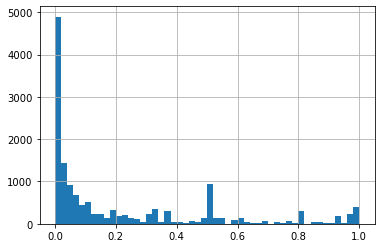

In [81]:
test_df['Random Forest probabilities'].hist(bins=50)

<AxesSubplot:>

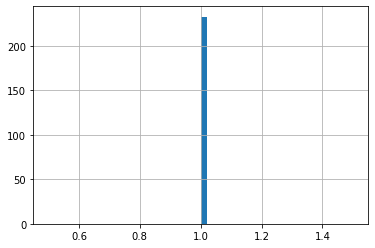

In [93]:
test_df[test_df['Random Forest probabilities']>=0.99]['Same_Complex']

In [43]:
def plot_roc_curves(results_dict, y_test):
    plt.figure(figsize=(10, 7))
    for name, result in results_dict.items():
        y_score = None
        if result['probabilities'] is not None:
            y_score = result['probabilities']
        elif result['decision_scores'] is not None:
            y_score = result['decision_scores']
        
        if y_score is not None:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('full_train_test_roc.png',dpi=300)
    plt.show()

def plot_pr_curves(results_dict, y_test):
    plt.figure(figsize=(10, 7))
    for name, result in results_dict.items():
        y_score = None
        if result['probabilities'] is not None:
            y_score = result['probabilities']
        elif result['decision_scores'] is not None:
            y_score = result['decision_scores']
        
        if y_score is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            ap = average_precision_score(y_test, y_score)
            plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig('full_train_test_auprc.png', dpi=300)
    plt.show()

In [36]:
y_test

1         1
20        1
22        1
28        1
33        1
         ..
651614    0
651626    0
651639    0
651653    0
651688    0
Name: Same_Complex, Length: 14778, dtype: int64

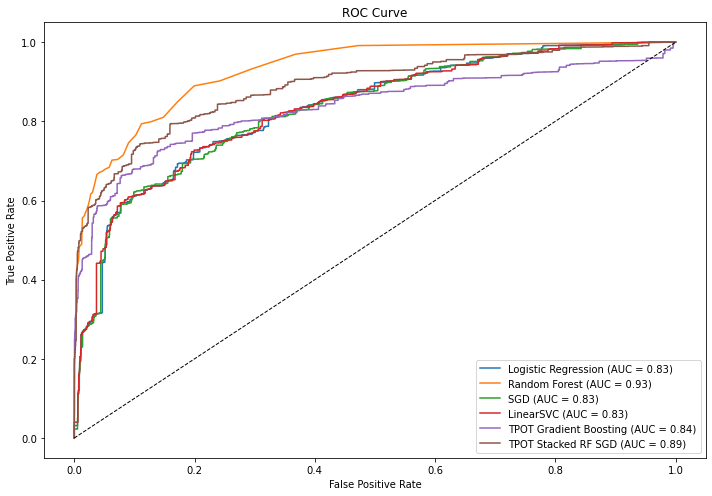

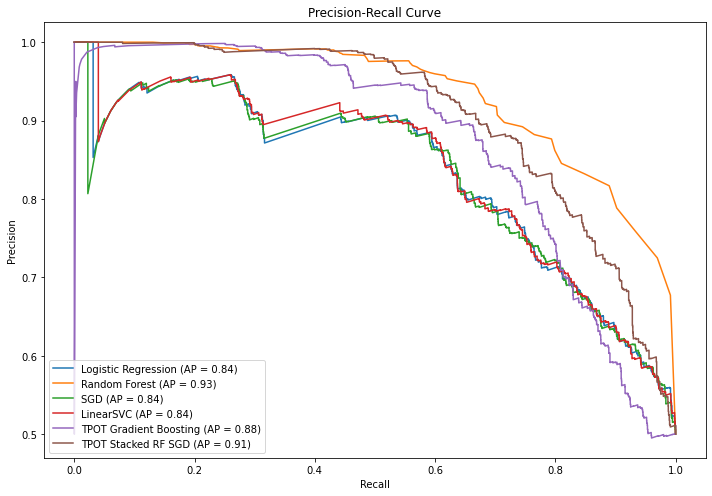

In [44]:
plot_roc_curves(all_model_results, y_test)
plot_pr_curves(all_model_results, y_test)

In [96]:
test_df.columns

Index(['Gene_B', 'complex_id_B', 'Gene_A', 'complex_id_A', 'global_index',
       'scGPT_bc_embeddings_Cosine_Similarity',
       'scGPT_pancancer_embeddings_Cosine_Similarity',
       'scGPT_CP_embeddings_Cosine_Similarity',
       'scGPT_lung_embeddings_Cosine_Similarity',
       'scGPT_heart_embeddings_Cosine_Similarity',
       'scGPT_brain_embeddings_Cosine_Similarity',
       'scGPT_kidney_embeddings_Cosine_Similarity',
       'scGPT_human_embeddings_Cosine_Similarity',
       'GF-6L30M_HUMANemb_Cosine_Similarity',
       'GF-20L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95M_HUMANemb_Cosine_Similarity',
       'GF-12L95MCANCER_UNIPROT_HUMANemb_Cosine_Similarity',
       'GF-12L30M_HUMANemb_Cosine_Similarity', 'Correlation', 'Gene_1',
       'Gene_2', 'pair_id', 'pairwise_label', 'Same_Complex', 'group_id',
       'Test', 'Logistic Regression predictions',
       'Logistic Regression probabilities',
       'Logistic Regression decision_scores', 'Random Forest predictions',
   

In [102]:
RF = test_df[["Gene_A", "Gene_B", "Random Forest probabilities", "Random Forest decision_scores"]].copy()

In [104]:
RF["Prob_Bin"] = pd.cut(RF["Random Forest probabilities"], bins=5, labels=False, include_lowest=True)

In [105]:
# Number of pairs to sample per bin
N = 5

sampled_pairs = (
    RF.groupby("Prob_Bin")
    .apply(lambda x: x.sample(min(len(x), N), random_state=42))
    .reset_index(drop=True)
)

In [107]:
sampled_pairs

,Gene_A,Gene_B,Random Forest probabilities,Random Forest decision_scores,Prob_Bin
0,MAD2L1,C1RL,0.02,None,0
1,NUAK1,OOEP,0.03,None,0
2,DLL4,FOXD4L4,0.00,None,0
3,SNAPC3,SNAPC2,0.10,None,0
4,ATF7,ATP6V1C2,0.00,None,0
5,MLST8,MTOR,0.28,None,1
6,LAMC1,LAMB1,0.36,None,1
7,SGCB,SNTA1,0.23,None,1
8,WASHC3,WASHC4,0.31,None,1
9,MIS12,NSL1,0.34,None,1


In [108]:
import requests
import time

def get_uniprot_fasta(gene_name, organism="Homo sapiens"):
    query = f'gene:{gene_name} AND organism:"{organism}" AND reviewed:true'
    url = f"https://rest.uniprot.org/uniprotkb/stream?query={query}&format=fasta"

    response = requests.get(url)
    if response.status_code == 200 and response.text.startswith(">"):
        return response.text.strip()
    else:
        return None  # Could not retrieve sequence

# Apply to unique gene names in your sampled pairs
unique_genes = pd.unique(sampled_pairs[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fasta = {}
for gene in unique_genes:
    fasta = get_uniprot_fasta(gene)
    if fasta:
        gene_to_fasta[gene] = fasta
    else:
        print(f"Sequence not found for gene: {gene}")
    time.sleep(1)  # be kind to the API

Sequence not found for gene: MAD2L1
Sequence not found for gene: C1RL
Sequence not found for gene: NUAK1
Sequence not found for gene: OOEP
Sequence not found for gene: DLL4
Sequence not found for gene: FOXD4L4
Sequence not found for gene: SNAPC3
Sequence not found for gene: SNAPC2
Sequence not found for gene: ATF7
Sequence not found for gene: ATP6V1C2
Sequence not found for gene: MLST8
Sequence not found for gene: MTOR
Sequence not found for gene: LAMC1
Sequence not found for gene: LAMB1
Sequence not found for gene: SGCB
Sequence not found for gene: SNTA1
Sequence not found for gene: WASHC3
Sequence not found for gene: WASHC4
Sequence not found for gene: MIS12
Sequence not found for gene: NSL1
Sequence not found for gene: GABRB3
Sequence not found for gene: GABRG2
Sequence not found for gene: COX19
Sequence not found for gene: KLHL36
Sequence not found for gene: C7orf25
Sequence not found for gene: OTUD6B
Sequence not found for gene: BRCA1
Sequence not found for gene: BARD1
Sequence no

In [109]:
gene_to_fasta

{}

In [110]:
def get_uniprot_id_from_gene(gene_name, organism="Homo sapiens"):
    url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        "query": f'gene_exact:{gene_name} AND organism:"{organism}"',
        "fields": "accession",
        "format": "tsv",
        "size": 1  # only get top hit
    }
    r = requests.get(url, params=params)
    if r.ok and "Entry" in r.text:
        return r.text.strip().split("\n")[1].strip()
    else:
        return None

def get_fasta_from_uniprot_id(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    r = requests.get(url)
    return r.text.strip() if r.ok else None

gene_to_fasta = {}
for gene in unique_genes:
    fasta = get_uniprot_fasta(gene)
    if not fasta:
        uniprot_id = get_uniprot_id_from_gene(gene)
        if uniprot_id:
            fasta = get_fasta_from_uniprot_id(uniprot_id)

    if fasta:
        gene_to_fasta[gene] = fasta
    else:
        print(f"Sequence not found for gene: {gene}")

    time.sleep(1)



Sequence not found for gene: MAD2L1
Sequence not found for gene: C1RL
Sequence not found for gene: NUAK1
Sequence not found for gene: OOEP
Sequence not found for gene: DLL4
Sequence not found for gene: FOXD4L4
Sequence not found for gene: SNAPC3
Sequence not found for gene: SNAPC2
Sequence not found for gene: ATF7
Sequence not found for gene: ATP6V1C2
Sequence not found for gene: MLST8
Sequence not found for gene: MTOR
Sequence not found for gene: LAMC1
Sequence not found for gene: LAMB1
Sequence not found for gene: SGCB
Sequence not found for gene: SNTA1
Sequence not found for gene: WASHC3
Sequence not found for gene: WASHC4
Sequence not found for gene: MIS12
Sequence not found for gene: NSL1
Sequence not found for gene: GABRB3
Sequence not found for gene: GABRG2
Sequence not found for gene: COX19
Sequence not found for gene: KLHL36
Sequence not found for gene: C7orf25
Sequence not found for gene: OTUD6B
Sequence not found for gene: BRCA1
Sequence not found for gene: BARD1
Sequence no

In [113]:
from Bio import Entrez, SeqIO
import time

Entrez.email = "brianna.flynn@utexas.edu"  # Required for NCBI Entrez access

def fetch_protein_fasta_from_gene(gene_name, organism="Homo sapiens"):
    try:
        search_handle = Entrez.esearch(
            db="protein",
            term=f"{gene_name}[Gene Name] AND {organism}[Organism]",
            retmode="xml",
            retmax=1
        )
        search_results = Entrez.read(search_handle)
        search_handle.close()

        if not search_results["IdList"]:
            return None

        protein_id = search_results["IdList"][0]
        fetch_handle = Entrez.efetch(
            db="protein",
            id=protein_id,
            rettype="fasta",
            retmode="text"
        )
        fasta_data = fetch_handle.read()
        fetch_handle.close()
        return fasta_data.strip()
    except Exception as e:
        print(f"Error retrieving {gene_name}: {e}")
        return None

# Run the test
test_fasta = fetch_protein_fasta_from_gene("SRP68")
print(test_fasta)

>NP_001247432.1 signal recognition particle subunit SRP68 isoform 3 [Homo sapiens]
MLSECRDAIQVVREELKPDQKQRDYILEGEPGKVSNLQYLHSYLTYIKLSTAIKRNENMAKGLQRALLQQ
QPEDDSKRSPRPQDLIRLYDIILQNLVELLQLPGLEEDKAFQKEIGLKTLVFKAYRCFFIAQSYVLVKKW
SEALVLYDRVLKYANEVNSDAGAFKNSLKDLPDVQELITQVRSEKCSLQAAAILDANDAHQTETSSSQVK
DNKPLVERFETFCLDPSLVTKQANLVHFPPGFQPIPCKPLFFDLALNHVAFPPLEDKLEQKTKSGLTGYI
KGIFGFRS


In [114]:
unique_genes = pd.unique(sampled_pairs[["Gene_A", "Gene_B"]].values.ravel())

gene_to_fasta = {}
for gene in unique_genes:
    fasta = fetch_protein_fasta_from_gene(gene)
    if fasta:
        gene_to_fasta[gene] = fasta
    else:
        print(f"No FASTA found for {gene}")
    time.sleep(1)  # be polite to NCBI


In [115]:
gene_to_fasta

{'MAD2L1': '>sp|Q13257.1|MD2L1_HUMAN RecName: Full=Mitotic spindle assembly checkpoint protein MAD2A; Short=HsMAD2; AltName: Full=Mitotic arrest deficient 2-like protein 1; Short=MAD2-like protein 1\nMALQLSREQGITLRGSAEIVAEFFSFGINSILYQRGIYPSETFTRVQKYGLTLLVTTDLELIKYLNNVVE\nQLKDWLYKCSVQKLVVVISNIESGEVLERWQFDIECDKTAKDDSAPREKSQKAIQDEIRSVIRQITATVT\nFLPLLEVSCSFDLLIYTDKDLVVPEKWEESGPQFITNSEEVRLRSFTTTIHKVNSMVAYKIPVND',
 'C1RL': '>NP_001284572.1 complement C1r subcomponent-like protein isoform 4 precursor [Homo sapiens]\nMPGPRVWGKYLWRSPHSKGCPGAMWWLLLWGVLQACPTRGSVLLAQELPQQLTSPGYPEPYGKGQESSTD\nIKAPEGFAVRLVFQDFDLEPSQDCAGDSVTISFVGSDPSQFCGQQGSPLGRPPGQREFVSSGRSLRLTFR\nTQPSSENKTAHLHKGFLALYQTVGECPSWGCREGASVPSHDPGIFKP',
 'NUAK1': '>NP_055655.1 NUAK family SNF1-like kinase 1 [Homo sapiens]\nMEGAAAPVAGDRPDLGLGAPGSPREAVAGATAALEPRKPHGVKRHHHKHNLKHRYELQETLGKGTYGKVK\nRATERFSGRVVAIKSIRKDKIKDEQDMVHIRREIEIMSSLNHPHIISIYEVFENKDKIVIIMEYASKGEL\nYDYISERRRLSERETRHFFRQIVSAVHYCHKNGVVHRDLKLENILLDDNCNIKIADFGLSNLYQKDKFLQ\nTFCG

In [117]:
import os
output_dir = "colabfold_inputs"
os.makedirs(output_dir, exist_ok=True)

for idx, row in sampled_pairs.iterrows():
    fasta_a = gene_to_fasta.get(row["Gene_A"])
    fasta_b = gene_to_fasta.get(row["Gene_B"])

    if fasta_a and fasta_b:
        with open(f"{output_dir}/pair_{idx}_bin{row['Prob_Bin']}.fasta", "w") as f:
            f.write(fasta_a + "\n" + fasta_b + "\n")
    else:
        print(f"Skipping {row['Gene_A']} and {row['Gene_B']} | MISSING sequence")

In [123]:
test_df.drop(columns=['Gene_1', 'Gene_2', 'Test'], inplace=True)

In [124]:
test_df.to_csv('test_dataset_with_model_probs_preds_decision-scores.csv',index=False)

In [126]:
RF.to_csv('binned_randomforest_probs_decision-scores.csv', index=False)